In [40]:
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt

In [41]:
def leer_gadget2_por_tipo(path_del_archivo):
    with open(path_del_archivo, "rb") as f:
        # Leer header
        f.seek(0)
        _ = struct.unpack("I", f.read(4))[0]
        header_bytes = f.read(256)
        _ = struct.unpack("I", f.read(4))[0]

        # numero_de_particulas = número de partículas por tipo_de_particula
        numero_de_particulas = struct.unpack("6I", header_bytes[0:24])
        masas_del_header = struct.unpack("6d", header_bytes[24:72])  # masas por tipo_de_particula si son iguales
        total_de_particulas = sum(numero_de_particulas)
        tipos_presentes = [i for i, n in enumerate(numero_de_particulas) if n > 0]

        print(f"Tipos presentes: total de particulas: {list(zip(tipos_presentes, numero_de_particulas))}")
        print(f"Total de partículas: {total_de_particulas:,}")

        # Leer POS
        _ = struct.unpack("I", f.read(4))[0]
        posiciones = np.fromfile(f, dtype=np.float32, count=total_de_particulas * 3).reshape((total_de_particulas, 3))
        _ = struct.unpack("I", f.read(4))[0]

        # Leer VEL
        _ = struct.unpack("I", f.read(4))[0]
        velocidades = np.fromfile(f, dtype=np.float32, count=total_de_particulas * 3).reshape((total_de_particulas, 3))
        _ = struct.unpack("I", f.read(4))[0]

        # Leer IDs
        _ = struct.unpack("I", f.read(4))[0]
        ids = np.fromfile(f, dtype=np.uint32, count=total_de_particulas)
        _ = struct.unpack("I", f.read(4))[0]

        # Leer masas si hay (algunas simulaciones lo hacen)
        masas = None

        try:
            _ = struct.unpack("I", f.read(4))[0]
            masas = np.fromfile(f, dtype=np.float32, count=total_de_particulas)
            _ = struct.unpack("I", f.read(4))[0]

        except:
         masas = None

    # Separar los datos por tipo_de_particula de partícula
    bases_de_datos_por_tipo = {}
    offset = 0

    for tipo_de_particula, cantidad_de_particulas in enumerate(numero_de_particulas):
        
        if cantidad_de_particulas == 0:
            continue

        # Obtener fragmentos por tipo_de_particula
        posicion = posiciones[offset : offset + cantidad_de_particulas]
        velocidad = velocidades[offset : offset + cantidad_de_particulas]
        id = ids[offset : offset + cantidad_de_particulas]

        if masas is not None:
            masa = masas[offset : offset + cantidad_de_particulas]

        elif masas_del_header[tipo_de_particula] != 0:
            masa = np.full(cantidad_de_particulas, masas_del_header[tipo_de_particula])
            
        else:
            masa = None

        informacion_galaxia = {
            "id": id,
            "x": posicion[:, 0],
            "y": posicion[:, 1],
            "z": posicion[:, 2],
            "vx": velocidad[:, 0],
            "vy": velocidad[:, 1],
            "vz": velocidad[:, 2]
        }

        if masa is not None:
            informacion_galaxia["masa"] = masa

        componente_df = pd.DataFrame(informacion_galaxia)
        bases_de_datos_por_tipo[str(tipo_de_particula)] = componente_df

        offset += cantidad_de_particulas

    return bases_de_datos_por_tipo

# Uso
archivo = r"Archivos\AM2229-735_host_RL_050"
dfs = leer_gadget2_por_tipo(archivo)

materia_oscura_df = dfs['1']
disco_df = dfs['2']
bulbo_df = dfs['3']


Tipos presentes: total de particulas: [(1, 0), (2, 2339761), (3, 1396500)]
Total de partículas: 4,334,761


In [42]:
disco_df

,id,x,y,z,vx,vy,vz,masa
0,2485768,19.249180,-8.902871,-2.388173,90.120422,220.290955,-4.888204,0.000004
1,2775065,20.102970,-10.197082,-2.608376,78.788292,235.908401,6.253386,0.000004
2,3279277,18.791067,-9.970717,-3.121269,79.470818,197.341141,5.856361,0.000004
3,3022572,19.271641,-10.648118,-2.600253,133.701401,207.172928,3.227269,0.000004
4,2807744,18.710337,-11.869731,-2.614120,100.917839,177.581360,2.891580,0.000004
...,...,...,...,...,...,...,...,...
1396495,2822860,10.750190,3.744227,1.571682,-146.960007,142.777695,99.647224,0.000004
1396496,3366462,10.870271,2.426959,1.823923,-173.339661,154.903290,119.643013,0.000004
1396497,2898833,10.503703,2.148110,1.827323,-86.982437,225.740189,-57.582195,0.000004
1396498,3537760,10.388523,2.368616,1.435702,-148.966049,150.551071,51.405407,0.000004


In [43]:
def centrar_galaxia(base_de_datos):
    
    masa_total_galaxia = base_de_datos.masa.sum()

    x_cm = base_de_datos.masa @ base_de_datos.x / masa_total_galaxia
    y_cm = base_de_datos.masa @ base_de_datos.y / masa_total_galaxia
    z_cm = base_de_datos.masa @ base_de_datos.z / masa_total_galaxia

    vx_cm = base_de_datos.masa @ base_de_datos.vx / masa_total_galaxia
    vy_cm = base_de_datos.masa @ base_de_datos.vy / masa_total_galaxia
    vz_cm = base_de_datos.masa @ base_de_datos.vz / masa_total_galaxia
    
    # Posiciones trasladadas
    base_de_datos['x0'] = base_de_datos.x - x_cm
    base_de_datos['y0'] = base_de_datos.y - y_cm
    base_de_datos['z0'] = base_de_datos.z - z_cm

    # Velocidades trasladadas
    base_de_datos['vx0'] = base_de_datos.vx - vx_cm
    base_de_datos['vy0'] = base_de_datos.vy - vy_cm
    base_de_datos['vz0'] = base_de_datos.vz - vz_cm

centrar_galaxia(materia_oscura_df)
centrar_galaxia(disco_df)
centrar_galaxia(bulbo_df)

In [44]:
def rotar_galaxia(base_de_datos):
    lx = (base_de_datos.y0 @ base_de_datos.vz0) - (base_de_datos.z0 @ base_de_datos.vy0)
    ly = (base_de_datos.z0 @ base_de_datos.vx0) - (base_de_datos.x0 @ base_de_datos.vz0)
    lz = (base_de_datos.x0 @ base_de_datos.vy0) - (base_de_datos.y0 @ base_de_datos.vx0)

    magnitud_l = np.linalg.norm((lx, ly, lz))

    angulo_z = np.atan(ly / lx)
    angulo_y = np.acos(lz / magnitud_l)
     
    cos_z = np.cos(angulo_z)
    sin_z = np.sin(angulo_z)
    cos_y = np.cos(angulo_y)
    sin_y = np.sin(angulo_y)

    # Rotar posiciones
    base_de_datos['x_f'] = (
        base_de_datos.x0 * (cos_y * cos_z) + 
        base_de_datos.y0 * (cos_y * sin_z) +
        base_de_datos.z0 * (-sin_y)
        )
    
    base_de_datos['y_f'] = (
        base_de_datos.x0 * (- sin_z) + 
        base_de_datos.y0 * (cos_z)
        )

    base_de_datos['z_f'] = (
        base_de_datos.x0 * (sin_y * cos_z) + 
        base_de_datos.y0 * (sin_y * sin_z) +
        base_de_datos.z0 * (cos_y)
        )
    
    # Rotar velocidades
    base_de_datos['vx_f'] = (
        base_de_datos.vx0 * (cos_y * cos_z) + 
        base_de_datos.vy0 * (cos_y * sin_z) +
        base_de_datos.vz0 * (-sin_y)
        )
    
    base_de_datos['vy_f'] = (
        base_de_datos.vx0 * (- sin_z) + 
        base_de_datos.vy0 * (cos_z)
        )

    base_de_datos['vz_f'] = (
        base_de_datos.vx0 * (sin_y * cos_z) + 
        base_de_datos.vy0 * (sin_y * sin_z) +
        base_de_datos.vz0 * (cos_y)
        )

rotar_galaxia(materia_oscura_df)
rotar_galaxia(disco_df)
rotar_galaxia(bulbo_df)


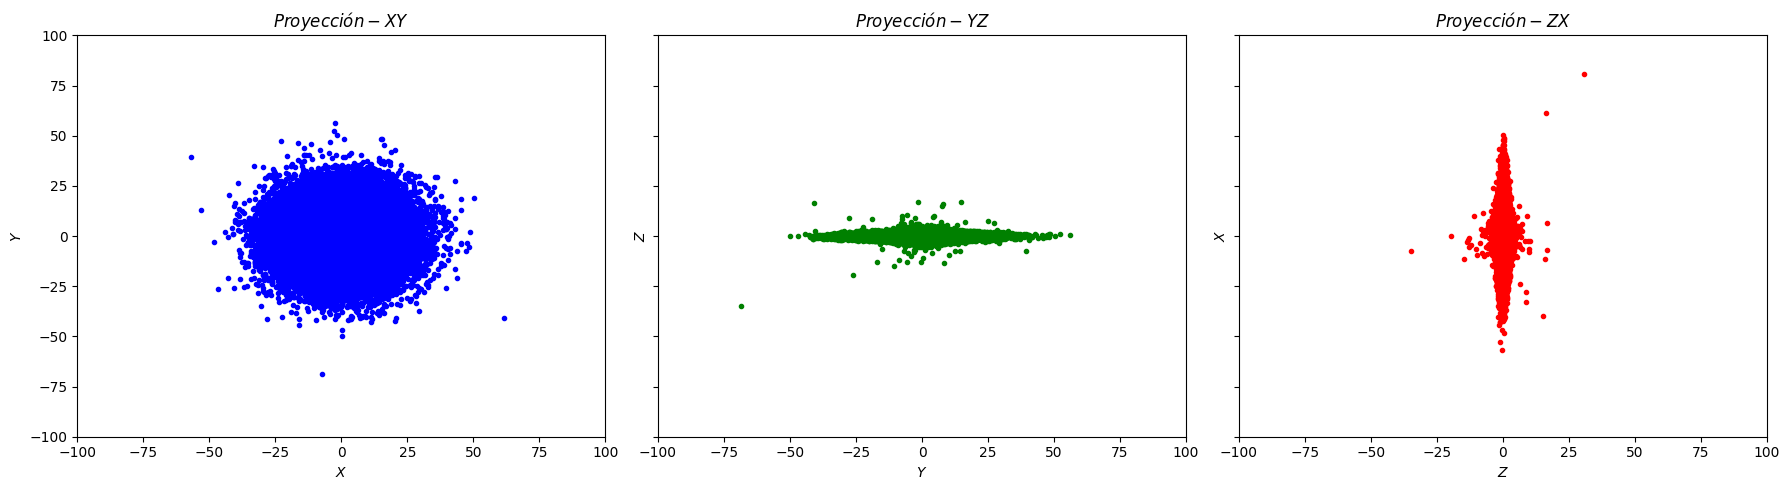

In [ ]:
def graficar_proyecciones(base_de_datos, x, y, z, limites_x = (None, None), limites_y = (None, None)):

    # Creamos una figura con 3 subplots en una sola fila (1 fila, 3 columnas)
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)  # Ancho x alto en pulgadas

    # Primer gráfico: masa vs radio
    axs[0].scatter(base_de_datos[x], base_de_datos[y], color='blue', marker= '.')
    axs[0].set_title(r'$Proyección-XY$')
    axs[0].set_xlabel(r'$X$')
    axs[0].set_ylabel(r'$Y$')
    axs[0].set_xlim(limites_x[0], limites_x[1])
    axs[0].set_ylim(limites_y[0], limites_y[1])

    # Segundo gráfico
    axs[1].scatter(base_de_datos[y], base_de_datos[z], color='green', marker= '.')
    axs[1].set_title(r'$Proyección-YZ$')
    axs[1].set_xlabel(r'$Y$')
    axs[1].set_ylabel(r'$Z$')

    # Tercer gráfico
    axs[2].scatter(base_de_datos[z], base_de_datos[x], color='red', marker= '.')
    axs[2].set_title(r'$Proyección-ZX$')
    axs[2].set_xlabel(r'$Z$')
    axs[2].set_ylabel(r'$X$')

    # Ajustar los espacios entre los subplots para evitar superposición
    plt.tight_layout()
    plt.show()
    
graficar_proyecciones(disco_df, 'x_f', 'y_f', 'z_f', limites_x=(-100, 100), limites_y=(-100,100))


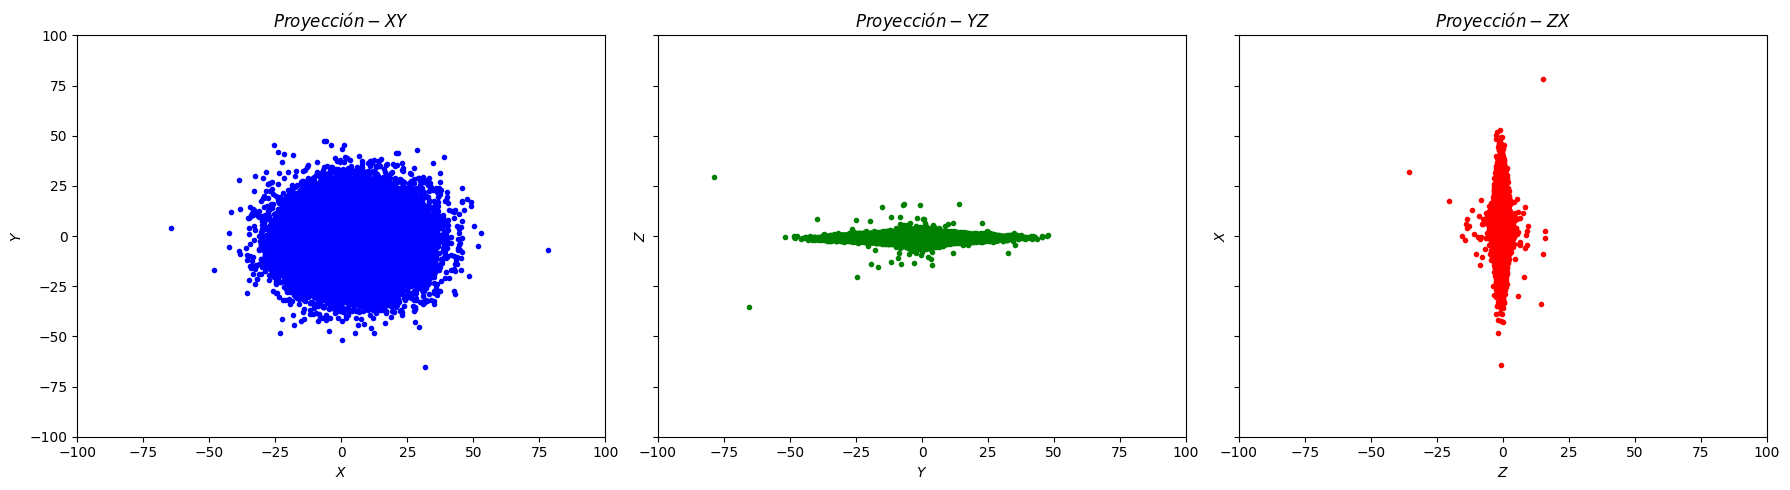

In [46]:
disco_profe_df = pd.read_csv(r'Archivos\disco_profe.2', delimiter=' ', header=None, names=['id', 'x_f', 'y_f', 'z_f', 'vx_f', 'vy_f', 'vz_f', 'masa'])
graficar_proyecciones(disco_profe_df, 'x_f', 'y_f', 'z_f', limites_x=(-100, 100), limites_y=(-100,100))


In [47]:
disco_df['r_xy'] = np.sqrt( disco_df.x_f**2 + disco_df.y_f**2)
# disco_df['r_xyz'] = np.sqrt(disco_df.r_xy**2 + disco_df.z_f**2)
disco_df

,id,x,y,z,vx,vy,vz,masa,x0,y0,...,vx0,vy0,vz0,x_f,y_f,z_f,vx_f,vy_f,vz_f,r_xy
0,2485768,19.249180,-8.902871,-2.388173,90.120422,220.290955,-4.888204,0.000004,14.802010,-6.837011,...,88.330444,221.029816,-4.479268,9.494988,-13.259914,-1.574042,186.057007,148.479034,-3.644195,16.308897
1,2775065,20.102970,-10.197082,-2.608376,78.788292,235.908401,6.253386,0.000004,15.655800,-8.131222,...,76.998314,236.647263,6.662323,9.598453,-14.806988,-1.793783,183.875641,167.656586,7.487716,17.645884
2,3279277,18.791067,-9.970717,-3.121269,79.470818,197.341141,5.856361,0.000004,14.343897,-7.904858,...,77.680840,198.080002,6.265297,8.572225,-13.961746,-2.311286,165.407394,133.792892,7.007792,16.383327
3,3022572,19.271641,-10.648118,-2.600253,133.701401,207.172928,3.227269,0.000004,14.824471,-8.582258,...,131.911423,207.911789,3.636205,8.652811,-14.788152,-1.789904,217.420837,115.533806,4.612136,17.133610
4,2807744,18.710337,-11.869731,-2.614120,100.917839,177.581360,2.891580,0.000004,14.263166,-9.803871,...,99.127861,178.320221,3.300516,7.561110,-15.572644,-1.808671,174.297287,106.014694,4.082884,17.311199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396495,2822860,10.750190,3.744227,1.571682,-146.960007,142.777695,99.647224,0.000004,6.303020,5.810086,...,-148.749985,143.516556,100.056160,8.340470,1.935140,2.380672,-58.816902,198.284363,99.793167,8.562021
1396496,3366462,10.870271,2.426959,1.823923,-173.339661,154.903290,119.643013,0.000004,6.423101,4.492818,...,-175.129639,155.642151,120.051949,7.792612,0.730690,2.630455,-75.844589,221.864380,119.712723,7.826795
1396497,2898833,10.503703,2.148110,1.827323,-86.982437,225.740189,-57.582195,0.000004,6.056533,4.213969,...,-88.772415,226.479050,-57.173260,7.336113,0.669480,2.631806,35.033886,240.756775,-57.016586,7.366598
1396498,3537760,10.388523,2.368616,1.435702,-148.966049,150.551071,51.405407,0.000004,5.941353,4.434476,...,-150.756027,151.289932,51.814342,7.346740,0.918098,2.240230,-56.501907,206.033295,51.561256,7.403884


In [48]:
delta_r_xy = 0.2

In [49]:
disco_df.r_xy.max()

np.float32(2418.1316)

In [50]:
np.int32((disco_df.r_xy.max() - disco_df.r_xy.min()) / delta_r_xy)

np.int32(12090)

In [51]:
np.linspace(disco_df.r_xy.min(), disco_df.r_xy.max(), np.int32((disco_df.r_xy.max() - disco_df.r_xy.min()) / delta_r_xy))

array([7.5355601e-03, 2.0756237e-01, 4.0758917e-01, ..., 2.4177317e+03,
       2.4179316e+03, 2.4181316e+03], shape=(12090,), dtype=float32)